# AGRON 935 - Semester project

**Name:** Javier Fernandez <br/>
**Semester:** Spring 2019 <br/>
**Project area:** Agronomy <br/>

### Motivation for the project

The objective is to create a code that can determine and calculate the HTT (Hourly Thermal Time) and DTT (Daily Thermal Time) using Kansas Mesonet database for grain filling samples. Periods of time for HTT and DTT calculations will be between a flowering date (starting point) and a sampling date for each data point.

Moreover, the code will allow the user to choose a minimum and maximum cardinal temperatures for calculations on HTT and DTT. This will be useful to evaluate and compare different base temperatures for grain filling.

## Table of contents
1. [Import modules](#import_modules)
2. [Import data](#import_data)
3. [Establish location of desired weather data](#weather_input)
4. [Handling missing values](#missing_values)
5. [Calculate thermal time for each day](#daily_TT)
6. [Sumation of thermal time for each sample](#sample_TT)
7. [Plotting the two calculated methods of GDD](#plotting)

Input files neccesary are:

  - Sampling or biomass data in a time series. Especifically, should have columns for an observed date point (here is a sampling date) and a starting date of reference (here is date of flowering).

<a name="import_modules"></a>
#### 1. Import modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<a name="import_data"></a>
#### 2. Import data

<span style="color:red">__==> User input required__</span>

The user is required to input the data to analyze at this step. As an example we will use a sample data on grain filling in corn. Samples were collected from plants with identified flowering dates.

We will obtain this example data from my github repository.

In [3]:
# Working directory for the project files
dirname = 'https://raw.githubusercontent.com/jafernandez01/project/master/Data/'

# There are two alternatives to open the sample database
#df = pd.read_csv(dirname + 'sample_dat.csv') # we can obtain the data directly from the web, calling github
df = pd.read_csv('Data/sample_dat.csv') # in case we have downloaded the repository we can work with the file located in the 'Data' folder
df = pd.DataFrame(df)
df.head() # for this case G, T, S, and Time are just values representing treatments and experimental design

,Plot,G,T,S,Time,Sampling,Flowering,DW_mg
0,101,1,1,1,1,7/20/2017,7/8/2017,28.2436
1,102,2,2,2,1,7/20/2017,7/7/2017,39.0236
2,103,3,3,3,1,7/20/2017,7/8/2017,25.0096
3,104,1,2,4,1,7/20/2017,7/9/2017,37.0832
4,105,2,3,5,1,7/20/2017,7/8/2017,24.2550


In [4]:
# Here we need to define the name of the columns that we will be using for thermal time calculations.
# In this examples, the start date is in the 'Flowering' column, while the end date is in the 'Sampling' column. 
# Also, we define the variable of interest

start_column = 'Flowering' 
end_column = 'Sampling'
variable = 'DW_mg'

# Note = modifications by the user are required above in order to be adaptable for any other column names.

df = df.rename(columns={start_column: 'start_column', end_column: 'end_column'})

<a name="weather_input"></a>
#### 3. Establish location of desired weather data

To obtain the weather data we will need to set the location of our experiment. A list of all available weather stations in kansas mesonet can be found here: https://github.com/jafernandez01/project/blob/master/Data/station_names.csv

<span style="color:red">__==> User input required.__</span>


In [97]:
# Here the code will ask the user to input the name of the weather station.

stn = input('Enter a valid weather station capitalizing the first letter of every word:')
stn = stn.replace(" ", "%20")

Enter a valid weather station capitalizing the first letter of every word: Ashland Bottoms


In [98]:
# Defining the URL string to obtain the data in a .csv file

root = 'http://mesonet.k-state.edu/rest/stationdata/?'

intervalD = 'day'
intervalH = 'hour'

df['end_column'] = pd.to_datetime(df['end_column'], format='%m/%d/%Y')
df['start_column'] = pd.to_datetime(df['start_column'], format='%m/%d/%Y')

# Starting and end points for daily data
start_timeD = df['start_column'].min().strftime('%Y%m%d12%M%S') # Hours = 12 (noon) because in mesonet it is when daily averages are computed
end_timeD = df['end_column'].max().strftime('%Y%m%d12%M%S')

# Starting and end points for hourly data
start_timeH = df['start_column'].min().strftime('%Y%m%d%H%M%S')
end_timeH = df['end_column'].max().strftime('%Y%m%d23%M%S') # Hours = 23 to grab the complete last day and make it comparable to all other dates

urlD = root + 'stn=' + stn + '&int=' + intervalD + '&t_start=' + start_timeD + '&t_end=' + end_timeD
urlH = root + 'stn=' + stn + '&int=' + intervalH + '&t_start=' + start_timeH + '&t_end=' + end_timeH

In [99]:
# Obtaining the daily weather file

wtrD = pd.read_csv(urlD)

#Renaming and dropping unused columns
wtrD = wtrD.iloc[:,[0,7,8]] # keep only selected columns
wtrD = wtrD.rename(columns={'TIMESTAMP': 'Day', 'TEMP2MMIN': 'Min', 'TEMP2MMAX': 'Max'})

# Converting values to type = float. Errors = coerce return invalid conversions to Nan
wtrD['Min'] = pd.to_numeric(wtrD['Min'], errors='coerce')
wtrD['Max'] = pd.to_numeric(wtrD['Max'], errors='coerce')

# Calculating daily mean temperatures
wtrD['Average'] = ((wtrD['Min']) + (wtrD['Max']))/2

wtrD.head()

,Day,Min,Max,Average
0,2017-07-06 00:00:00,16.75,31.35,24.050
1,2017-07-07 00:00:00,17.69,34.41,26.050
2,2017-07-08 00:00:00,17.35,30.60,23.975
3,2017-07-09 00:00:00,14.52,32.30,23.410
4,2017-07-10 00:00:00,18.98,34.89,26.935


In [100]:
# Similar steps to obtain the hourly weather file

wtrH = pd.read_csv(urlH)

#Renaming and dropping unused columns
wtrH = wtrH.iloc[:,[0,4]] # keep only selected columns
wtrH = wtrH.rename(columns={'TIMESTAMP': 'Day', 'TEMP2MAVG': 'Temp'})

# Converting values to type = float. Errors = coerce return invalid conversions to Nan
wtrH['Temp'] = pd.to_numeric(wtrH['Temp'], errors='coerce') 

# As the day column contains the day and the hour, we need to separate in two columns these values
# For this we split that column based on the space between strings
new = wtrH["Day"].str.split(" ", expand = True) 
 
wtrH.drop(columns =["Day"])  # Drop the old "Day" column

wtrH["Day"]= new[0]
wtrH["Time"]= new[1]

wtrH.head(3).append(wtrH.tail(3))  # Print the first three and last three rows to check that the data is OK

,Day,Temp,Time
0,2017-07-05,19.79,00:00:00
1,2017-07-05,19.03,01:00:00
2,2017-07-05,18.43,02:00:00
1869,2017-09-20,24.32,21:00:00
1870,2017-09-20,24.01,22:00:00
1871,2017-09-20,23.73,23:00:00


In [101]:
# Some last adjustment to the variables. Here we set the dates as a same format for all the values we will be using

df['end_column'] = pd.to_datetime(df['end_column'], format='%m/%d/%Y')
df['start_column'] = pd.to_datetime(df['start_column'], format='%m/%d/%Y')
wtrD['Day'] = pd.to_datetime(wtrD['Day'], format='%Y/%m/%d')
wtrH['Day'] = pd.to_datetime(wtrH['Day'], format='%Y/%m/%d')

<a name="missing_values"></a>
#### 4. Handling missing values

In [102]:
# Let's first check missing values in our dataframes

#print(df.isna().sum())
#print(wtrH.isna().sum())
#print(wtrD.isna().sum())

In this example we only have missing values in our hourly data. The way we will handle Nan will be:

- For the sample or biomaass database, if missing values are encountered (in this example, is 1 row) we will just drop that row or measurement.

- For the weather database, both hourly and daily, missing temperatures will be estimated with the previous recorded value. In this case, we only have some missing values in the hourly weather file.

In [103]:
df = df[pd.notnull(df[variable])] # Drop rows that are not null in the DW_mg column

wtrH = wtrH.interpolate() # interpolate function is filling NaN in a Series via linear interpolation, using both the previous and next values.

# wtrD = wtrD.interpolate() # same approach for the daily data, although in this case it is not neccesary.

<a name="daily_TT"></a>
#### 5. Calculate thermal time for each day

##### __DTT (daily thermal time) Method__

We will use McMaster and Wilhelm (1997) method for calculating DTT, which has been widely used in studies. It assumes a linear relationship using the mean daily temperature, with an upper critical value.

- Tmax is the maximum temperature, Tmin is the minimum temperature, Tavg = (Tmax + Tmin)/2 
- Tbase is the base temperature = 8 C
- Tupp is the upper threshold temperature = 40 C

Input = Tmin and Tmax (daily)

<br/>


##### __HTT (hourly thermal time) Method__

We will use a beta function (Zhou and Wang, 2018) to calculate HTT. 

Yin et al. (1995) first proposed the use of a beta function containing three parameters (the cardinal temperatures) to describe simulations of the development of several crops.

This approach accounts for the asymmetric temperature response for the developmental rate and the decline in the rate above T opt.
- Tbase = 8 C
- Topt = 33 C
- Tupp = 40 C
  
Input = T hourly

_* all temperatures values are referenced for corn development_


<span style="color:red"> **Note: the user can modify inside each function the cardinal temperatures (base, optimal, and upper) according to his preferences. </span>

In [104]:
# We define two functions to calculate growing degree for each day: one for the first method using DTT, and the second for the HTT method.

def GDD_D (T_avg, tbase=8, Tupp = 40):
    if T_avg <= tbase:
        GD = 0
    elif T_avg >= Tupp:
        GD = Tupp - tbase
    else:
        GD = T_avg - tbase
    
    return GD

def GDD_H (T_hourly, tbase=8, Tupp = 40, Topt = 30):
    if T_hourly <= tbase:
        HD = 0
    elif T_hourly >= Tupp:
        HD = 0
    else:
        HD = (((T_hourly - tbase)/(Topt - tbase))*(((Tupp - T_hourly)/(Tupp - Topt))**((Tupp - Topt)/(Topt - tbase))) * (Topt - tbase))
    
    return HD



# We apply the function to each row in the daily weather file and we store it into a new column named GDD_D.
wtrD['GDD_D'] = wtrD.Average.apply(GDD_D)
#wtrD.head()

# We apply the function to each row in the hourly weather file and we store it into a new column named GDD_H.
wtrH['GDD_H'] = wtrH.Temp.apply(GDD_H)
#wtrH.head()

<a name="sample_TT"></a>
#### 6. Sumation of thermal time for each sample

In [105]:
# In this section we are going to calculate the sum of GDD or thermal time for our samples based on the GDD colums of the weather file.

# We define two functions (one for each method) that perform the sumation indexing on starting and end dates (sampling and flowering).

def calc_D (start, end):
      
    TT = wtrD[(wtrD.Day >= start) & (wtrD.Day <= end)].GDD_D.sum()
    return TT

def calc_H (start, end):
      
    TT = (wtrH[(wtrH.Day >= start) & (wtrH.Day <= end)].GDD_H.sum()) / 24 # we divide by 24 because we are summing 24 values per considered day
    return TT


# Then we need to iterate this two functions across all my rows in the dataframe. The intertuples method is useful to call each row.

daily_list = [] # create two empty lists
hourly_list = [] 
for row in df.itertuples():
    TT_D = calc_D(row.start_column, row.end_column)
    daily_list.append(TT_D)   #append the TT values for each row in a list
    
    TT_H = calc_H(row.start_column, row.end_column)
    hourly_list.append(TT_H)   #append the TT values for each row in a list

    
# Add both lists as new columns (GDD_D and GDD_H) in our dataframe:

df['GDD_D'] = np.asarray(daily_list)
df['GDD_H'] = np.asarray(hourly_list)
df.head().append(df.tail())  

,Plot,G,T,S,Time,end_column,start_column,DW_mg,GDD_D,GDD_H
0,101,1,1,1,1,2017-07-20,2017-07-08,28.2436,261.265,262.133369
1,102,2,2,2,1,2017-07-20,2017-07-07,39.0236,279.315,282.555230
2,103,3,3,3,1,2017-07-20,2017-07-08,25.0096,261.265,262.133369
3,104,1,2,4,1,2017-07-20,2017-07-09,37.0832,245.290,243.962031
4,105,2,3,5,1,2017-07-20,2017-07-08,24.2550,261.265,262.133369
427,305,1,3,5,16,2017-09-20,2017-07-08,326.5542,1192.320,1360.908646
428,306,3,1,6,16,2017-09-20,2017-07-09,307.8744,1176.345,1342.737308
429,307,1,3,7,16,2017-09-20,2017-07-09,348.4614,1176.345,1342.737308
430,308,2,1,8,16,2017-09-20,2017-07-09,242.6418,1176.345,1342.737308
431,309,2,2,9,16,2017-09-20,2017-07-08,321.6642,1192.320,1360.908646


In [106]:
# Now we can export our table as a new .csv file in our directory
df.to_csv('GDD_calculated.csv')

<a name="plotting"></a>
#### 7. Plotting the two calculated methods of GDD

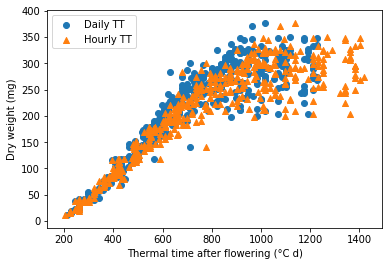

In [107]:
plt.scatter(df.GDD_D, df.DW_mg, marker = 'o', label = 'Daily TT')
plt.scatter(df.GDD_H, df.DW_mg, marker = '^', label = 'Hourly TT')
plt.xlabel('Thermal time after flowering (°C d)')
plt.ylabel('Dry weight (mg)')
plt.legend()
plt.show()